####  

- Update future: pip install -U future

- Download the data:
- https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- Download the word vectors:
- http://nlp.stanford.edu/data/glove.6B.zip
   or
- https://drive.google.com/uc?id=1WJjHzuxJwiioEB8hluWcYC0SnjiZN-1v&export=download

In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input,GlobalMaxPooling1D
from keras.layers import Conv1D,MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


#### Configuration

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


#### Load in pre-trained word vectors

- Raw data is in txt format, each row start with word and follow by vector
- Convert to dictionary

In [4]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype = 'float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


#### Prepare text samples and their labels

- Target shape -- N*6
- N is the samples
- 6 is possible label


In [5]:
train = pd.read_csv("large_files/toxic-comment/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
print('Loading in comments...')

sentences = train['comment_text'].fillna("DUMMY_VALUE").values
sentences
possible_labels = ["toxic",'severe_toxic',"obscene","threat","insult","identity_hate"]
targets = train[possible_labels].values

print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:",s[len(s)//2])

Loading in comments...
max sequence length: 5000
min sequence length: 6
median sequence length: 205


#### Convert the sentences into integers

In [7]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences[1])

sequences: [52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


#### Get word >> integer mapping

In [8]:
## Mapping dictionary
word2idx = tokenizer.word_index

print("Found %s unique tokens." % len(word2idx))

Found 210337 unique tokens.


#### Pad sequences so that we get a N*T matrix

- N: Samples
- T: Length

In [9]:
data = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)
print("shape of data tensor:",data.shape)

shape of data tensor: (159571, 100)


#### Prepare embedding matrix

- In Keras word tokenizer, 0 is for unknown, real word start from 1
- use get function, if word not exist in dict, return None

- embedding -- V * D
- V: Vocabulary size 
- D: Dimension

In [10]:
print('Filling pre-trained embeddings...')

num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)  ## real word start from 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i <MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


#### load pre-trained word embeddings into an Embedding layer
#### note that we set trainable = False so as to keep the embeddings fixed

In [11]:
embedding_layer = Embedding(num_words,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable = False)

###### Global Max Pool
- have a time series and we don't care how long it is, just take the max value in the time series in each dimension
- T * M --> Global max pool --> M
- choosing whick point in time was the most important for computing

#### train a 1D convnet with global maxpooling

In [13]:
print("Building the model...")

input_ = Input(shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128,activation = 'relu')(x)
output = Dense(len(possible_labels),activation = 'sigmoid')(x)

model = Model(input_,output)
model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

print('Training model...')

r = model.fit(data,
             targets,
             batch_size = BATCH_SIZE,
             epochs = EPOCHS,
             validation_split = VALIDATION_SPLIT,
             verbose = 1)


Building the model...
Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 20s 158us/step - loss: 0.0836 - acc: 0.9733 - val_loss: 0.0757 - val_acc: 0.9765
Epoch 2/10
127656/127656 [==============================] - 20s 159us/step - loss: 0.0670 - acc: 0.9773 - val_loss: 0.0790 - val_acc: 0.9725
Epoch 3/10
127656/127656 [==============================] - 20s 159us/step - loss: 0.0627 - acc: 0.9784 - val_loss: 0.0830 - val_acc: 0.9751
Epoch 4/10
127656/127656 [==============================] - 20s 156us/step - loss: 0.0599 - acc: 0.9793 - val_loss: 0.0717 - val_acc: 0.9778
Epoch 5/10
127656/127656 [==============================] - 19s 152us/step - loss: 0.0579 - acc: 0.9796 - val_loss: 0.0733 - val_acc: 0.9776
Epoch 6/10
127656/127656 [==============================] - 19s 151us/step - loss: 0.0561 - acc: 0.9804 - val_loss: 0.0852 - val_acc: 0.9771
Epoch 7/10
127656/127656 [==============================] - 19s

#### Plot some data

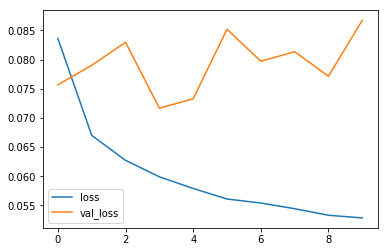

In [14]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

#### Accuracy

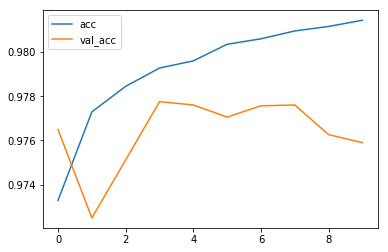

In [16]:
plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

#### plot the mean AUC over each label

In [17]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
    
print(np.mean(aucs))

0.9669035666829364
